In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import datetime
import geobr
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams['axes.grid'] = False
plt.rcParams['font.size'] = '10'

In [3]:
idw_path = r'.\1 - Organized data gauge\BRAZIL\NetCDF\IDW_optimization'
cn_path_station = r'.\1 - Organized data gauge\NormaisClimatologicas\Estacoes'
cn_path_prec = r'.\1 - Organized data gauge\NormaisClimatologicas\Prec'

In [4]:
def calculate_metrics(group_data):
    if np.std(group_data['rain_mm']) == 0 or np.std(group_data['interpolated_rain_mm']) == 0:
        # If any of the arrays is constant, return NaN for correlation coefficient and 0 for bias and RMSE
        return np.nan, 0, 0
    else:
        # Calculate correlation coefficient
        r_value, _ = pearsonr(group_data['rain_mm'], group_data['interpolated_rain_mm'])

        # Calculate bias
        bias = np.mean(group_data['interpolated_rain_mm'] - group_data['rain_mm'])

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(group_data['rain_mm'], group_data['interpolated_rain_mm']))

        return r_value, bias, rmse


In [5]:
df_interpolation = pd.read_hdf(cn_path_prec + "\\BRASIL_CLIMATOLOGICAL_NORMALS.h5", key='table_data_1961_1990')
df_interpolation['Date'] = pd.to_datetime(df_interpolation['Date'])
df_interpolation['Year'] = df_interpolation['Date'].dt.year
df_interpolation['Month'] = df_interpolation['Date'].dt.month
df_interpolation.sort_values(['Date'], ascending=True, ignore_index=True, inplace= True)
df_interpolation

,Código,Nome,UF,Latitude_Decimal,Longitude_Decimal,Altitude (m),interpolated_rain_mm,Date,Year,Month
0,83010,Brasiléia,AC,-11.016667,-68.733333,260.00,12.2057178585898,1961-01-01,1961,1
1,83718,Cordeiro,RJ,-22.016667,-42.350000,505.92,1.6051874053756623,1961-01-01,1961,1
2,83807,Carmo,RJ,-21.933333,-42.600000,342.19,8.51789132439609,1961-01-01,1961,1
3,83698,Campos,RJ,-21.750000,-41.333333,11.20,10.290871098847983,1961-01-01,1961,1
4,83719,Cabo Frio (Alcalis),RJ,-22.983333,-42.033333,7.00,2.010232040653793,1961-01-01,1961,1
...,...,...,...,...,...,...,...,...,...,...
4317053,83589,Conceição do Mato Dentro,MG,-19.016667,-43.433333,652.00,0.16125547989020492,1990-12-31,1990,12
4317054,83686,Caxambu,MG,-21.966667,-44.933333,958.51,0.0,1990-12-31,1990,12
4317055,83027,Cataguases,MG,-21.383333,-42.683333,167.97,0.0,1990-12-31,1990,12
4317056,83514,Capinópolis,MG,-18.716667,-49.550000,620.60,0.08012154235407265,1990-12-31,1990,12


In [6]:
df_interpolation_month = df_interpolation[['Código', 'Month', 'interpolated_rain_mm']].groupby(['Código', 'Month']).sum().divide(30).reset_index(drop=False, inplace=False)
df_interpolation_month['Month'] = df_interpolation_month['Month'].apply(lambda x: pd.Timestamp(year=1990, month=x, day=1).strftime('%B'))
df_interpolation_month

,Código,Month,interpolated_rain_mm
0,82024,January,114.579913
1,82024,February,89.267391
2,82024,March,134.903423
3,82024,April,197.317757
4,82024,May,251.712766
...,...,...,...
4723,83997,August,96.893117
4724,83997,September,98.223798
4725,83997,October,81.981911
4726,83997,November,86.861654


In [7]:
df_cn_prec = pd.read_excel(cn_path_prec + "\\NC_PREC_1961_1990.xlsx")
df_cn_prec.sort_values('Year', inplace=True, ignore_index=True)
df_cn_prec.dropna(inplace=True, ignore_index=True)
df_cn_prec

,Código,Nome,UF,January,February,March,April,May,June,July,August,September,October,November,December,Year
0,82987,Petrolândia,PE,49.8,69.1,112.0,68.2,22.1,11.0,14.1,2.4,3.2,10.4,14.8,51.0,428.1
1,82594,Macau,RN,29.7,64.8,120.0,134.5,73.8,35.5,26.7,5.7,4.8,0.8,2.6,8.3,507.2
2,82983,Petrolina,PE,81.9,105.9,136.3,93.6,21.7,5.1,8.7,2.4,5.6,11.9,53.5,50.8,577.4
3,82886,Cabrobó,PE,87.2,85.8,136.1,104.6,40.4,19.4,13.5,3.8,4.1,10.5,38.8,55.4,599.5
4,82986,Paulo Afonso,BA,63.4,62.5,97.1,84.9,67.5,54.4,52.2,21.3,16.5,17.3,25.4,47.1,609.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,82106,S. G. da Cachoeira (Uaupés),AM,286.4,231.8,241.7,294.1,325.6,285.8,247.6,193.7,194.2,180.1,191.4,261.9,2934.0
327,82100,Paricachoeira,AM,219.7,228.2,330.0,341.6,402.5,340.0,325.4,293.3,210.7,228.9,199.6,216.9,3336.9
328,82105,Rio Içana,AM,248.7,228.3,289.2,345.5,464.9,373.0,274.9,290.5,263.2,212.6,237.7,231.8,3460.2
329,82067,Iauaretê,AM,292.4,217.0,299.3,353.1,417.3,368.7,350.6,278.5,255.4,259.1,223.4,241.0,3555.7


In [8]:
df_cn_prec_month = pd.melt(df_cn_prec, id_vars=['Código', 'Nome', 'UF'], var_name='Month', value_name='rain_mm')
# df.rename(columns={'Month': 'Month_Name'}, inplace=True)
df_cn_prec_month = df_cn_prec_month[df_cn_prec_month['Month'] != 'Year']
print(df_cn_prec_month.dtypes)
df_cn_prec_month

Código       int64
Nome        object
UF          object
Month       object
rain_mm    float64
dtype: object


,Código,Nome,UF,Month,rain_mm
0,82987,Petrolândia,PE,January,49.8
1,82594,Macau,RN,January,29.7
2,82983,Petrolina,PE,January,81.9
3,82886,Cabrobó,PE,January,87.2
4,82986,Paulo Afonso,BA,January,63.4
...,...,...,...,...,...
3967,82106,S. G. da Cachoeira (Uaupés),AM,December,261.9
3968,82100,Paricachoeira,AM,December,216.9
3969,82105,Rio Içana,AM,December,231.8
3970,82067,Iauaretê,AM,December,241.0


In [9]:
df_result = pd.merge(df_cn_prec_month, df_interpolation_month[["Código", "Month", "interpolated_rain_mm"]], how = 'left', on = ['Código', 'Month'])
df_result

,Código,Nome,UF,Month,rain_mm,interpolated_rain_mm
0,82987,Petrolândia,PE,January,49.8,59.338628
1,82594,Macau,RN,January,29.7,35.635948
2,82983,Petrolina,PE,January,81.9,80.530686
3,82886,Cabrobó,PE,January,87.2,83.235657
4,82986,Paulo Afonso,BA,January,63.4,53.783743
...,...,...,...,...,...,...
3967,82106,S. G. da Cachoeira (Uaupés),AM,December,261.9,254.197205
3968,82100,Paricachoeira,AM,December,216.9,239.98785
3969,82105,Rio Içana,AM,December,231.8,238.264815
3970,82067,Iauaretê,AM,December,241.0,248.855968


In [10]:
r_value, p_value = pearsonr(df_result['rain_mm'], df_result['interpolated_rain_mm'])
print(r_value, p_value)

0.9721754760783385 0.0


In [11]:
# Calculate bias
bias = np.mean(df_result['interpolated_rain_mm'] - df_result['rain_mm'])
print(bias, bias/df_result['rain_mm'].mean()*100,"%")

-6.314098529715652 -5.008626405760864 %


In [12]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(df_result['rain_mm'], df_result['interpolated_rain_mm']))
print(rmse, rmse/df_result['rain_mm'].mean()*100,"%")

22.380587970013163 17.753287085323638 %


In [13]:
df_result['rain_mm'].mean()

126.06447393347705

In [14]:
df_statistics = df_result[['Código', 'Month', 'rain_mm', 'interpolated_rain_mm']].reset_index(inplace =False, drop = True)
# df_statistics.dropna(inplace=True)
df_statistics.dropna(inplace=True, ignore_index=True)
df_statistics['Month_Order'] = df_statistics['Month'].apply(lambda x: datetime.datetime.strptime(x, "%B").month)
df_statistics.sort_values(['Código', 'Month_Order'], ascending=True, inplace=True, ignore_index=True)
df_statistics

,Código,Month,rain_mm,interpolated_rain_mm,Month_Order
0,82024,January,25.1,114.579913,1
1,82024,February,18.1,89.267391,2
2,82024,March,30.9,134.903423,3
3,82024,April,88.5,197.317757,4
4,82024,May,213.0,251.712766,5
...,...,...,...,...,...
3967,83997,August,105.4,96.893117,8
3968,83997,September,113.3,98.223798,9
3969,83997,October,84.6,81.981911,10
3970,83997,November,83.8,86.861654,11


In [15]:
results_month = []
for group_name, group_data in df_statistics.groupby(['Month']):
    r_value, bias, rmse = calculate_metrics(group_data)
    # Append results to the list
    results_month.append({
        'Month': group_name[0],
        'R': r_value,
        'Bias': bias,
        'RMSE': rmse
    })

# Convert results to DataFrame
df_results_month = pd.DataFrame(results_month)
df_results_month['Month_Order'] = df_results_month['Month'].apply(lambda x: datetime.datetime.strptime(x, "%B").month)
df_results_month['Month_Desc'] = df_results_month['Month_Order'].apply(lambda x: '0' + str(x) if isinstance(x, int) and x < 10 else str(x))
df_results_month['Month_Desc'] = df_results_month['Month_Desc'] + " - " + df_results_month['Month']
df_results_month.sort_values(['Month_Desc'], ascending=True, inplace=True, ignore_index=True)
df_results_month

,Month,R,Bias,RMSE,Month_Order,Month_Desc
0,January,0.938695,-8.003492,28.183347,1,01 - January
1,February,0.934263,-8.597512,28.069456,2,02 - February
2,March,0.949389,-8.473514,28.404121,3,03 - March
3,April,0.964618,-5.327673,26.093033,4,04 - April
4,May,0.977059,-5.718986,21.078485,5,05 - May
5,June,0.977510,-4.681884,18.121220,6,06 - June
6,July,0.972550,-4.730317,17.394203,7,07 - July
7,August,0.977580,-3.232797,13.357057,8,08 - August
8,September,0.968655,-3.848619,13.870557,9,09 - September
9,October,0.954914,-7.792235,18.895466,10,10 - October


In [16]:
df_mean_month = df_statistics[['Month', 'rain_mm', 'interpolated_rain_mm']].groupby('Month').mean().reset_index(drop = False, inplace = False)
results_month = []
for group_name, group_data in df_statistics.groupby(['Month']):
    r_value, bias, rmse = calculate_metrics(group_data)
    # Append results to the list
    results_month.append({
        'Month': group_name[0],
        'R': r_value,
        'Bias': bias,
        'RMSE': rmse
    })
df_mean_month['Month_Order'] = df_mean_month['Month'].apply(lambda x: datetime.datetime.strptime(x, "%B").month)
df_mean_month['Month_Desc'] = df_mean_month['Month_Order'].apply(lambda x: '0' + str(x) if isinstance(x, int) and x < 10 else str(x))
df_mean_month['Month_Desc'] = df_mean_month['Month_Desc'] + " - " + df_mean_month['Month']
df_mean_month.sort_values(['Month_Desc'], ascending=True, inplace=True, ignore_index=True)
df_mean_month

,Month,rain_mm,interpolated_rain_mm,Month_Order,Month_Desc
0,January,196.465274,188.461781,1,01 - January
1,February,178.866099,170.268586,2,02 - February
2,March,186.679656,178.206143,3,03 - March
3,April,143.440999,138.113326,4,04 - April
4,May,105.900490,100.181505,5,05 - May
5,June,75.470934,70.78905,6,06 - June
6,July,67.207352,62.477036,7,07 - July
7,August,55.349009,52.116212,8,08 - August
8,September,72.510058,68.661439,9,09 - September
9,October,112.115538,104.323303,10,10 - October


# Climate Normals vs. Gridded Data

In [17]:
correlation_coefficient, p_value = pearsonr(df_mean_month['rain_mm'], df_mean_month['interpolated_rain_mm'])
# Display correlation coefficient and p-value

# Exibir o coeficiente de correlação e o p-valor formatado
print(f"Correlation coefficient: {correlation_coefficient:.3f}")
print(f"P-value: {p_value:.3f}")

alpha = 0.05  # Significance level

if p_value < alpha:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

Correlation coefficient: 1.000
P-value: 0.000
The correlation is statistically significant.


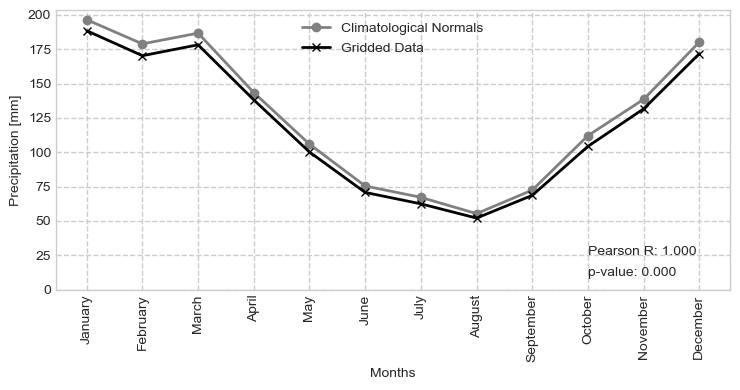

In [18]:
fig, ax1 = plt.subplots(figsize=(7.5, 4))

ax1.plot(df_mean_month['Month_Order'], df_mean_month['rain_mm'], color='grey',marker='o', label='Climatological Normals', linewidth=2)
ax1.set_xticks(df_mean_month['Month_Order'])
ax1.set_xticklabels(df_mean_month['Month'].values.tolist(),  rotation = 90)
ax1.grid(linestyle = '--', linewidth = 1, axis='both')
ax1.set_ylim(0, None)

ax1.plot(df_mean_month['Month_Order'], df_mean_month['interpolated_rain_mm'], color='black', marker='x', label='Gridded Data', linewidth=2)
# ax2.set_xticklabels([])


ax1.set_xlabel('Months')
ax1.set_ylabel('Precipitation [mm]')
# ax2.set_ylabel('\nNumber of data records')

# plt.title("Average Precipitation by Month\nGridded Data vs. Climate Normals from INMET (1961 - 1990)", **tnr_title)
plt.setp(plt.gca().get_xticklabels(), rotation=90)


# Legend
lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper center')
# ax1.legend(loc='upper left')

plt.text(10, 25, f'Pearson R: {correlation_coefficient:.3f}')
plt.text(10, 10, f'p-value: {p_value:.3f}')

plt.tight_layout() 

plt.savefig('./figures/climate_normal_vs_gridded_data_agg_months_1961_1990.tiff', format='tiff', dpi=300, bbox_inches='tight') 
plt.show()
plt.close()

# R - Pearson Correlation coefficient

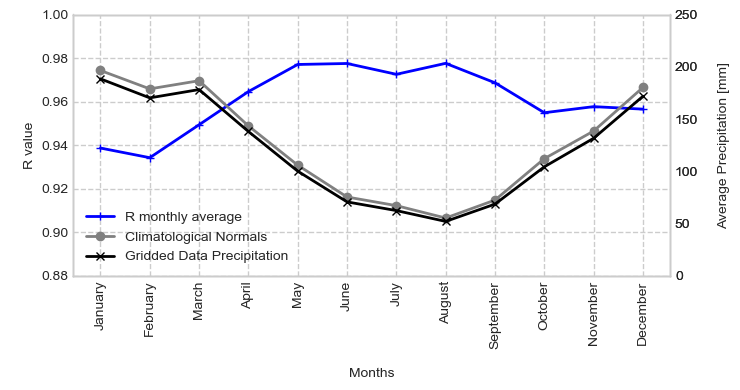

In [19]:
fig, ax1= plt.subplots(figsize=(7.5, 4))

ax1.plot(df_results_month['Month_Order'], df_results_month['R'], color='blue',marker='+', label='R monthly average', linewidth=2)
ax1.set_xticks(df_results_month['Month_Order'])
ax1.set_xticklabels(df_results_month['Month'].values.tolist(),  rotation = 90)
ax1.grid(linestyle = '--', linewidth = 1, axis='both')
ax1.set_ylim(0.88, 1)

# f'n = {len_df:.0f}'

ax2 = ax1.twinx()
ax2.plot(df_results_month['Month_Order'], df_mean_month['rain_mm'], color='grey',marker='o', label='Climatological Normals', linewidth=2)
# ax2.set_xticklabels([])
ax2.set_ylim(0, 250)

ax3 = ax1.twinx()
ax3.plot(df_results_month['Month_Order'], df_mean_month['interpolated_rain_mm'], color='black', marker='x', label='Gridded Data Precipitation', linewidth=2)
# ax2.set_xticklabels([])
ax3.set_ylim(0, 250)


ax1.set_xlabel('\nMonths')
ax1.set_ylabel('\nR value')
ax2.set_ylabel('\nAverage Precipitation [mm]')

# plt.title("R - Pearson correlation coefficient\nGridded Data vs. Climate Normals from INMET (1961 - 1990)\n", **tnr_title)
plt.setp(plt.gca().get_xticklabels(), rotation=90)


# Legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='lower left')

plt.tight_layout() 

plt.savefig('./figures/pearson_climate_normal_vs_gridded_data_agg_months_1961_1990.tiff', format='tiff', dpi=300, bbox_inches='tight') 
plt.show()
plt.close()


# Bias

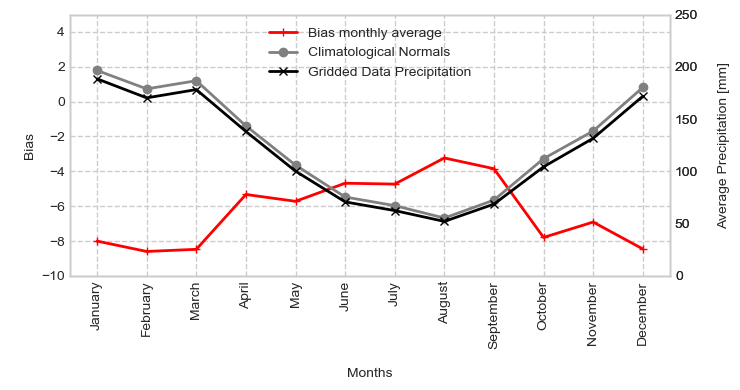

In [20]:
fig, ax1= plt.subplots(figsize=(7.5, 4))

ax1.plot(df_results_month['Month_Order'], df_results_month['Bias'], color='red',marker='+', label='Bias monthly average', linewidth=2)
ax1.set_xticks(df_results_month['Month_Order'])
ax1.set_xticklabels(df_results_month['Month'].values.tolist(),  rotation = 90)
ax1.grid(linestyle = '--', linewidth = 1, axis='both')

max_value = math.ceil(max(abs(min(df_results_month['Bias'])), max(df_results_month['Bias'])))
ax1.set_ylim(-10, 5)

# f'n = {len_df:.0f}'

ax2 = ax1.twinx()
ax2.plot(df_results_month['Month_Order'], df_mean_month['rain_mm'], color='grey',marker='o', label='Climatological Normals', linewidth=2)
# ax2.set_xticklabels([])
ax2.set_ylim(0, 250)

ax3 = ax1.twinx()
ax3.plot(df_results_month['Month_Order'], df_mean_month['interpolated_rain_mm'], color='black', marker='x', label='Gridded Data Precipitation', linewidth=2)
# ax2.set_xticklabels([])
ax3.set_ylim(0, 250)
ax3.grid(visible=False)


ax1.set_xlabel('\nMonths')
ax1.set_ylabel('\nBias')
ax2.set_ylabel('\nAverage Precipitation [mm]')

# plt.title("Bias\nGridded Data vs. Climate Normals from INMET (1961 - 1990)\n", **tnr_title)
plt.setp(plt.gca().get_xticklabels(), rotation=90)


# Legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper center')

plt.tight_layout() 
plt.savefig('./figures/bias_climate_normal_vs_gridded_data_agg_months_1961_1990.tiff', format='tiff', dpi=300, bbox_inches='tight') 
plt.show()
plt.close()


# RMSE

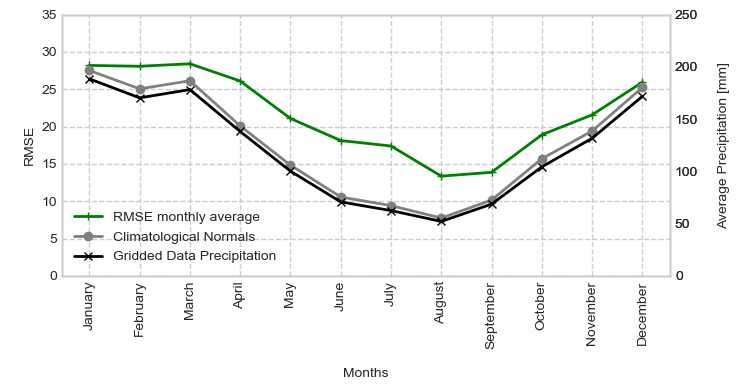

In [21]:
fig, ax1= plt.subplots(figsize=(7.5, 4))

ax1.plot(df_results_month['Month_Order'], df_results_month['RMSE'], color='green',marker='+', label='RMSE monthly average', linewidth=2)
ax1.set_xticks(df_results_month['Month_Order'])
ax1.set_xticklabels(df_results_month['Month'].values.tolist(),  rotation = 90)
ax1.grid(linestyle = '--', linewidth = 1, axis='both')

max_value = math.ceil(max(abs(min(df_results_month['RMSE'])), max(df_results_month['RMSE']))*1.05)
ax1.set_ylim(0, 35)

# f'n = {len_df:.0f}'

ax2 = ax1.twinx()
ax2.plot(df_results_month['Month_Order'], df_mean_month['rain_mm'], color='grey',marker='o', label='Climatological Normals', linewidth=2)
# ax2.set_xticklabels([])
ax2.set_ylim(0, 250)

ax3 = ax1.twinx()
ax3.plot(df_results_month['Month_Order'], df_mean_month['interpolated_rain_mm'], color='black', marker='x', label='Gridded Data Precipitation', linewidth=2)
# ax2.set_xticklabels([])
ax3.set_ylim(0, 250)
ax3.grid(visible=False)

# ax4 = ax1.twinx()
# ax4.axhline(0, linestyle='--', color='red', linewidth=5, alpha = 0.25)
# ax4.set_ylim(-max_value, +max_value)
# ax4.set_yticklabels([])
# ax4.tick_params(axis='y', length=0)
# ax4.grid(visible=False)

ax1.set_xlabel('\nMonths')
ax1.set_ylabel('\nRMSE')
ax2.set_ylabel('\nAverage Precipitation [mm]')

# plt.title("RMSE\nGridded Data vs. Climate Normals from INMET (1961 - 1990)\n", **tnr_title)
plt.setp(plt.gca().get_xticklabels(), rotation=90)


# Legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='lower left')

plt.tight_layout() 
plt.savefig('./figures/rmse_climate_normal_vs_gridded_data_agg_months_1961_1990.tiff', format='tiff', dpi=300, bbox_inches='tight') 
plt.show()
plt.close()


# Station Results

In [22]:
results_code_month = []
for group_name, group_data in df_statistics.groupby(['Código']):
    r_value, bias, rmse = calculate_metrics(group_data)
    # Append results to the list
    results_code_month.append({
        'Código': group_name[0],
        'R': r_value,
        'Bias': bias,
        'RMSE': rmse
    })

# Convert results to DataFrame
df_results_code_month = pd.DataFrame(results_code_month)
df_results_code_month

,Código,R,Bias,RMSE
0,82024,0.829713,27.201149,63.679411
1,82067,0.984253,-5.534471,12.076405
2,82093,0.976889,-1.487523,19.582984
3,82095,0.988256,5.555497,20.310024
4,82098,0.997125,-10.173129,14.758934
...,...,...,...,...
326,83966,0.905455,4.358246,15.875759
327,83967,0.955108,0.515976,6.760732
328,83980,0.962617,5.025147,7.050844
329,83995,0.915597,-12.982348,20.313520


In [23]:
def convert_degrees(string):
    parts = string.split('°')
    degrees = float(parts[0])
    minutes = float(parts[1].strip("'").split('\'')[0])
    direction = parts[1].strip("'").split('\'')[1]
    
    decimal_degrees = degrees + minutes / 60
    
    if direction == 'S' or direction == 'W':
        decimal_degrees *= -1
    
    return decimal_degrees

df_cn_station_1961_1990 = pd.read_excel(cn_path_station + "\\NC_ESTACOES_1961_1990.xlsx")
df_cn_station_1961_1990 = df_cn_station_1961_1990[["Código",	"Nome",	"UF",	"Latitude",	"Longitude",	"Altitude (m)"]]
df_cn_station_1961_1990['Latitude'] = df_cn_station_1961_1990['Latitude'].apply(convert_degrees)
df_cn_station_1961_1990['Longitude'] = df_cn_station_1961_1990['Longitude'].apply(convert_degrees)
df_cn_station_1961_1990

,Código,Nome,UF,Latitude,Longitude,Altitude (m)
0,83010,Brasiléia,AC,-11.016667,-68.733333,260.00
1,82704,Cruzeiro do Sul,AC,-7.633333,-72.666667,170.00
2,82915,Rio Branco,AC,-9.966667,-67.800000,160.00
3,82807,Tarauacá,AC,-8.166667,-70.766667,190.00
4,83098,Coruripe,AL,-10.150000,-36.166667,56.13
...,...,...,...,...,...,...
389,83231,Paranã,TO,-12.550000,-47.833333,275.00
390,82863,Pedro Afonso,TO,-8.966667,-48.183333,187.00
391,83228,Peixe,TO,-12.016667,-48.350000,242.49
392,83064,Porto Nacional,TO,-10.716667,-48.416667,239.20


In [24]:
df_geo = pd.merge(df_results_code_month, df_cn_station_1961_1990[["Código", "Latitude", "Longitude"]], how = 'left', on = ['Código'])
df_geo = gpd.GeoDataFrame(df_geo
                          , geometry = gpd.points_from_xy(df_geo['Longitude'], df_geo['Latitude'])
                          , crs="EPSG:4326")
df_geo.sort_values(['R'], ascending=False, inplace=True, ignore_index=True)
df_geo

,Código,R,Bias,RMSE,Latitude,Longitude,geometry
0,83423,0.999542,-0.553877,3.256817,-16.666667,-49.250000,POINT (-49.25 -16.66667)
1,83064,0.999297,-7.594197,10.954217,-10.716667,-48.416667,POINT (-48.41667 -10.71667)
2,83231,0.999092,-2.937713,5.691297,-12.550000,-47.833333,POINT (-47.83333 -12.55)
3,83235,0.999065,-0.582627,5.310698,-12.400000,-46.416667,POINT (-46.41667 -12.4)
4,82145,0.999014,-12.578857,19.359529,-1.066667,-46.900000,POINT (-46.9 -1.06667)
...,...,...,...,...,...,...,...
326,83957,0.595825,2.449065,17.238906,-30.333333,-54.316667,POINT (-54.31667 -30.33333)
327,83860,0.578711,15.032363,25.453896,-26.483333,-51.983333,POINT (-51.98333 -26.48333)
328,83883,0.530898,6.818854,19.831344,-27.116667,-52.616667,POINT (-52.61667 -27.11667)
329,83936,0.383367,-5.004242,12.856085,-29.700000,-53.700000,POINT (-53.7 -29.7)


In [25]:
df_geo.to_excel("./5 - Results/df_geo_1961_1990.xlsx", index=False, sheet_name='df_geo_1961_1990')

In [26]:
count_r_below_07 = (df_geo['R'] < 0.7).sum()
print(count_r_below_07)
df_geo_below_07 = df_geo[df_geo['R'] < 0.7]
df_geo_below_07

10


,Código,R,Bias,RMSE,Latitude,Longitude,geometry
321,83931,0.677657,3.816641,17.346682,-29.683333,-55.516667,POINT (-55.51667 -29.68333)
322,83864,0.666983,-11.177951,19.978777,-26.233333,-51.066667,POINT (-51.06667 -26.23333)
323,83912,0.658137,4.350993,15.810056,-28.633333,-53.600000,POINT (-53.6 -28.63333)
324,83929,0.648918,4.146405,23.101720,-29.166667,-56.500000,POINT (-56.5 -29.16667)
325,83907,0.635079,-4.941064,13.144141,-28.400000,-55.016667,POINT (-55.01667 -28.4)
326,83957,0.595825,2.449065,17.238906,-30.333333,-54.316667,POINT (-54.31667 -30.33333)
327,83860,0.578711,15.032363,25.453896,-26.483333,-51.983333,POINT (-51.98333 -26.48333)
328,83883,0.530898,6.818854,19.831344,-27.116667,-52.616667,POINT (-52.61667 -27.11667)
329,83936,0.383367,-5.004242,12.856085,-29.700000,-53.700000,POINT (-53.7 -29.7)
330,83887,0.291160,-19.082104,30.446598,-27.383333,-51.200000,POINT (-51.2 -27.38333)


C:\Users\linde\AppData\Local\Temp\ipykernel_14612\399911324.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  br_map['name_state'].replace({'AMAZÔNAS': 'AMAZONAS'}, inplace=True)


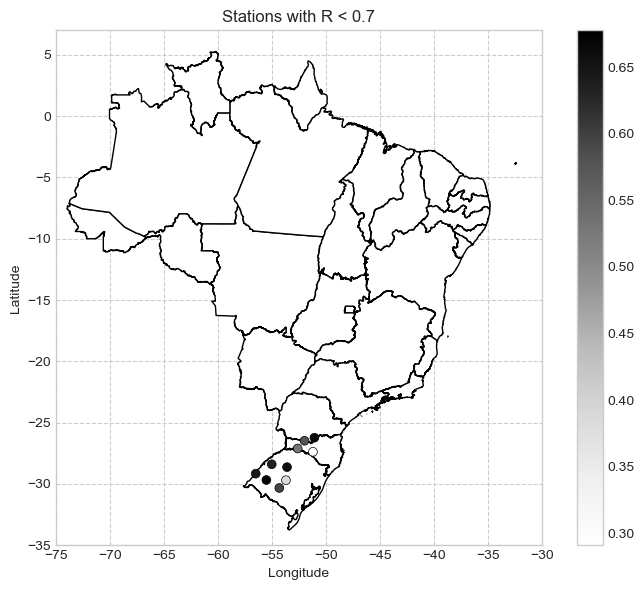

In [27]:
# Plot only the filtered stations (df_geo_below_07) on the map, colored by R value
br_map = geobr.read_state(year=2020)
br_map.crs = "EPSG:4326"
br_map['name_state'] = br_map['name_state'].apply(str.upper)
br_map = br_map.sort_values(by=['name_state'])
br_map['name_state'].replace({'AMAZÔNAS': 'AMAZONAS'}, inplace=True)

fig, ax = plt.subplots(figsize=(7.5, 6))
br_map.plot(ax=ax, color='white', edgecolor='black')
df_geo_below_07.plot(
    ax=ax,
    column='R',
    legend=True,
    alpha=1.0,
    markersize=40,
    edgecolor='black',
    linewidth=0.5
)
ax.set_ylim([-35, 7])
ax.set_xlim([-75, -30])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Stations with R < 0.7')
ax.grid(ls='--')
plt.tight_layout()
plt.show()
plt.close()

In [28]:
df_geo_extreme_bias = df_geo[(df_geo['Bias'] > 50) | (df_geo['Bias'] < -50)]
df_geo_extreme_bias

,Código,R,Bias,RMSE,Latitude,Longitude,geometry
108,82900,0.990226,-75.765461,89.917233,-8.050000,-35.016667,POINT (-35.01667 -8.05)
192,83806,0.979947,-51.565258,62.198227,-22.450000,-42.933333,POINT (-42.93333 -22.45)
193,82562,0.979415,-56.984658,77.445928,-5.366667,-49.133333,POINT (-49.13333 -5.36667)
304,83007,0.856999,-54.582169,58.299813,-22.950000,-43.266667,POINT (-43.26667 -22.95)


C:\Users\linde\AppData\Local\Temp\ipykernel_14612\1595424758.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  br_map['name_state'].replace({'AMAZÔNAS': 'AMAZONAS'}, inplace=True)


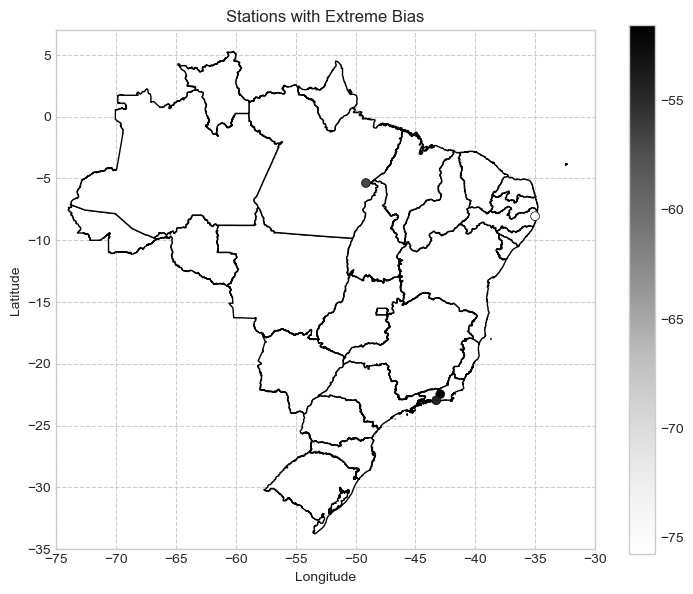

In [29]:

br_map = geobr.read_state(year=2020)
br_map.crs = "EPSG:4326"
br_map['name_state'] = br_map['name_state'].apply(str.upper)
br_map = br_map.sort_values(by=['name_state'])
br_map['name_state'].replace({'AMAZÔNAS': 'AMAZONAS'}, inplace=True)

fig, ax = plt.subplots(figsize=(7.5, 6))
br_map.plot(ax=ax, color='white', edgecolor='black')
df_geo_extreme_bias.plot(
    ax=ax,
    column='Bias',
    legend=True,
    alpha=1.0,
    markersize=40,
    edgecolor='black',
    linewidth=0.5
)
ax.set_ylim([-35, 7])
ax.set_xlim([-75, -30])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Stations with Extreme Bias')
ax.grid(ls='--')
plt.tight_layout()
plt.show()
plt.close()

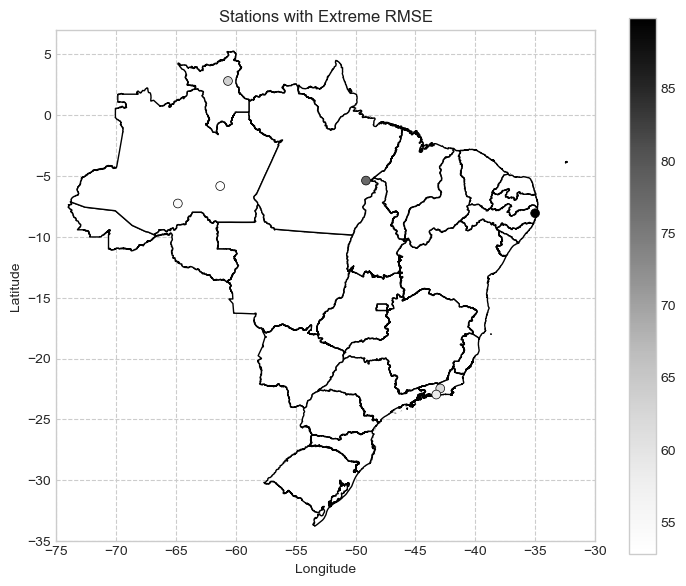

In [30]:
# Filter stations with extreme RMSE values (e.g., RMSE > 50)
extreme_rmse_threshold = 50
df_geo_extreme_rmse = df_geo[df_geo['RMSE'] > extreme_rmse_threshold]

# Plot the filtered stations on the map, colored by RMSE value
fig, ax = plt.subplots(figsize=(7.5, 6))
br_map.plot(ax=ax, color='white', edgecolor='black')
df_geo_extreme_rmse.plot(
    ax=ax,
    column='RMSE',
    legend=True,
    alpha=1.0,
    markersize=40,
    edgecolor='black',
    linewidth=0.5
)
ax.set_ylim([-35, 7])
ax.set_xlim([-75, -30])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Stations with Extreme RMSE')
ax.grid(ls='--')
plt.tight_layout()
plt.show()
plt.close()

In [31]:
df_geo.sort_values(['Bias'], ascending=False,  ignore_index=True)


,Código,R,Bias,RMSE,Latitude,Longitude,geometry
0,83782,0.978911,30.740326,41.418162,-23.933333,-46.333333,POINT (-46.33333 -23.93333)
1,82024,0.829713,27.201149,63.679411,2.816667,-60.650000,POINT (-60.65 2.81667)
2,83033,0.982790,26.523082,33.788585,-10.183333,-48.300000,POINT (-48.3 -10.18333)
3,83719,0.747393,25.548560,32.960586,-22.983333,-42.033333,POINT (-42.03333 -22.98333)
4,83921,0.760044,23.945842,31.859185,-28.883333,-49.516667,POINT (-49.51667 -28.88333)
...,...,...,...,...,...,...,...
326,82533,0.975910,-44.424235,52.810675,-5.816667,-61.300000,POINT (-61.3 -5.81667)
327,83806,0.979947,-51.565258,62.198227,-22.450000,-42.933333,POINT (-42.93333 -22.45)
328,83007,0.856999,-54.582169,58.299813,-22.950000,-43.266667,POINT (-43.26667 -22.95)
329,82562,0.979415,-56.984658,77.445928,-5.366667,-49.133333,POINT (-49.13333 -5.36667)


In [32]:
print(df_geo['R'].mean(), df_geo['Bias'].mean(), df_geo['RMSE'].mean())


0.9547278063258261 -6.314098529715643 19.454644740848092


In [33]:
df_geo.sort_values(['RMSE'], ascending=False,  ignore_index=True).head(25)


,Código,R,Bias,RMSE,Latitude,Longitude,geometry
0,82900,0.990226,-75.765461,89.917233,-8.050000,-35.016667,POINT (-35.01667 -8.05)
1,82562,0.979415,-56.984658,77.445928,-5.366667,-49.133333,POINT (-49.13333 -5.36667)
2,82024,0.829713,27.201149,63.679411,2.816667,-60.650000,POINT (-60.65 2.81667)
3,83806,0.979947,-51.565258,62.198227,-22.450000,-42.933333,POINT (-42.93333 -22.45)
4,83007,0.856999,-54.582169,58.299813,-22.950000,-43.266667,POINT (-43.26667 -22.95)
5,82723,0.981294,-43.318767,54.463101,-7.250000,-64.833333,POINT (-64.83333 -7.25)
6,82533,0.975910,-44.424235,52.810675,-5.816667,-61.300000,POINT (-61.3 -5.81667)
7,83223,0.900563,-10.854220,46.982763,-12.616667,-38.666667,POINT (-38.66667 -12.61667)
8,83758,0.885064,22.740156,46.056519,-23.000000,-44.033333,POINT (-44.03333 -23)
9,83192,0.743084,-33.350448,44.799575,-11.083333,-38.516667,POINT (-38.51667 -11.08333)


In [34]:
# Define custom colormap
bias_colors = [(0.710, 0.039, 0.165), (0.953, 0.592, 0.471), (0.85,0.85, 0.85),(0.553, 0.686, 0.992), (0.231, 0.302, 0.757),(0.553, 0.686, 0.992),(0.85,0.85, 0.85), (0.953, 0.592, 0.471), (0.710, 0.039, 0.165)]  # RGB values
bias_positions = [0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1]  # Color positions from 0 to 1

bias_cmap = LinearSegmentedColormap.from_list('bias_cmap', list(zip(bias_positions, bias_colors)))

bias_norm = mpl.colors.Normalize(vmin= -100, vmax= 100)



# Define custom colormap
r_colors = [(0.710, 0.039, 0.165), (0.953, 0.592, 0.471), (0.85,0.85, 0.85),(0.553, 0.686, 0.992), (0.231, 0.302, 0.757)]  # RGB values
r_positions = [0,0.25,0.5,0.75,1]  # Color positions from 0 to 1

r_cmap = LinearSegmentedColormap.from_list('r_cmap', list(zip(r_positions, r_colors)))

r_norm = mpl.colors.Normalize(vmin= 0.3, vmax= 1)



# Define custom colormap
rmse_colors = [(0.231, 0.302, 0.757), (0.553, 0.686, 0.992),(0.85,0.85, 0.85), (0.953, 0.592, 0.471), (0.710, 0.039, 0.165)]  # RGB values
rmse_positions = [0,0.25,0.5,0.75,1]  # Color positions from 0 to 1

rmse_cmap = LinearSegmentedColormap.from_list('r_cmap', list(zip(rmse_positions, rmse_colors)))

rmse_norm = mpl.colors.Normalize(vmin= 0, vmax= 100)

# R

C:\Users\linde\AppData\Local\Temp\ipykernel_14612\3466450954.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  br_map['name_state'].replace({'AMAZÔNAS': 'AMAZONAS'}, inplace=True)


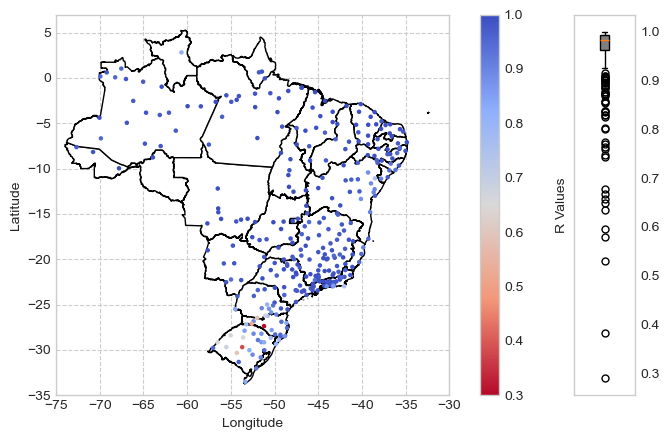

In [35]:
def createMapR(df):
    br_map = geobr.read_state(year=2020)
    br_map.crs = "EPSG:4326"
    br_map['name_state'] = br_map['name_state'].apply(str.upper)
    br_map = br_map.sort_values(by=['name_state'])
    br_map['name_state'].replace({'AMAZÔNAS': 'AMAZONAS'}, inplace=True)

    # Create a figure with two subplots (map + boxplot)
    fig, (ax_map, ax_box) = plt.subplots(1, 2, figsize=(7.5, 4.5), gridspec_kw={'width_ratios': [10, 1]})

    # Plot the map
    br_map.plot(ax=ax_map, color='white', edgecolor='black')
    df.plot(ax=ax_map,
            cmap = r_cmap,
            norm = r_norm,
            column='R',
            legend=True,
            alpha=1.0,
            markersize=5)

    ax_map.set_ylim([-35, 7])
    ax_map.set_xlim([-75, -30])
    ax_map.set_xlabel('Longitude')
    ax_map.set_ylabel('Latitude')
    ax_map.grid(ls='--')

    # Plot the boxplot
    ax_box.boxplot(df['R'], vert=True, patch_artist=True, boxprops=dict(facecolor='grey'), showfliers=True, flierprops=dict(marker='o', color='red', markersize=5))
    ax_box.set_ylabel('R Values')
    ax_box.yaxis.tick_right()  # Move ticks to the right
    ax_box.set_xticks([])  # Remove x-ticks for clarity

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig('./figures/climate_normal_R_stations_1961_1990.tiff', format='tiff', dpi=300, transparent=False, bbox_inches='tight')
    plt.show()
    plt.close()

createMapR(df_geo)

# Bias

C:\Users\linde\AppData\Local\Temp\ipykernel_14612\3181756826.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  br_map['name_state'].replace({'AMAZÔNAS': 'AMAZONAS'}, inplace = True)


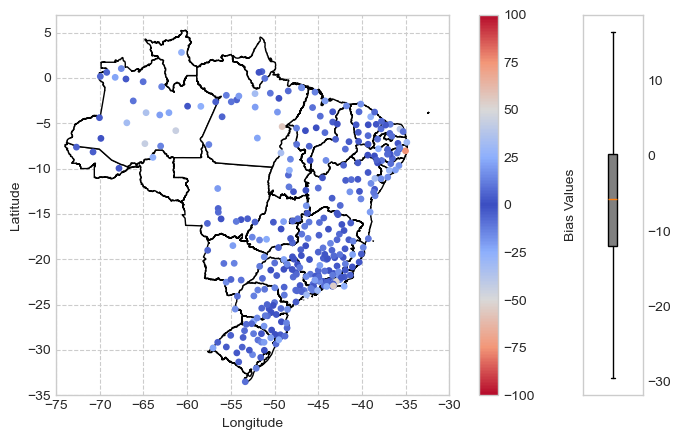

In [36]:
def createMapBias(df):
    br_map = geobr.read_state(year = 2020)
    br_map.crs = "EPSG:4326"
    br_map['name_state'] = br_map['name_state'].apply(str.upper)
    br_map = br_map.sort_values(by = ['name_state'])
    br_map['name_state'].replace({'AMAZÔNAS': 'AMAZONAS'}, inplace = True)
    

    # Create a figure with two subplots (map + boxplot)
    fig, (ax_map, ax_box) = plt.subplots(1, 2, figsize=(7.5, 4.5), gridspec_kw={'width_ratios': [10, 1]})
    br_map.plot(ax = ax_map, color = 'white', edgecolor = 'black')
    df.plot(ax = ax_map
            , column = 'Bias'
            , legend = True
            , cmap = bias_cmap
            , norm = bias_norm
            , alpha = 1.0
            , markersize = 15
            )

                    
    # ax_map.set_title("Bias", tnr_title)

    # Add colorbar
    # cbar = plt.colorbar(scatter1, label='Nearest Neighbor Distance (km)')

    ax_map.set_ylim([-35, 7])
    ax_map.set_xlim([-75, -30])
    ax_map.set_xlabel('Longitude')
    ax_map.set_ylabel('Latitude')
    ax_map.grid(ls='--')


    # Plot the boxplot
    ax_box.boxplot(df['Bias'], vert=True, patch_artist=True, boxprops=dict(facecolor='grey'), showfliers=False)
    ax_box.set_ylabel('Bias Values')
    ax_box.yaxis.tick_right()  # Move ticks to the right
    ax_box.set_xticks([])  # Remove x-ticks for clarity



    plt.tight_layout()
    plt.savefig('./figures/climate_normal_bias_stations_1961_1990.tiff', format='tiff', dpi=300, transparent=False, bbox_inches=None)
    plt.show()
    plt.close()

createMapBias(df_geo)

# RMSE

C:\Users\linde\AppData\Local\Temp\ipykernel_14612\4292668074.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  br_map['name_state'].replace({'AMAZÔNAS': 'AMAZONAS'}, inplace = True)


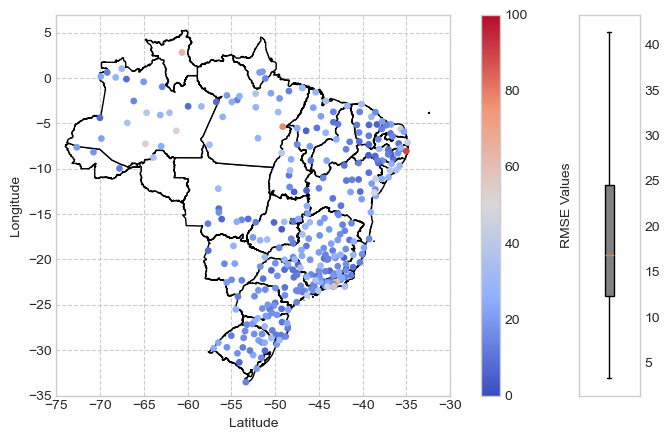

In [37]:
def createMapRMSE(df):
    br_map = geobr.read_state(year = 2020)
    br_map.crs = "EPSG:4326"
    br_map['name_state'] = br_map['name_state'].apply(str.upper)
    br_map = br_map.sort_values(by = ['name_state'])
    br_map['name_state'].replace({'AMAZÔNAS': 'AMAZONAS'}, inplace = True)


    # Create a figure with two subplots (map + boxplot)
    fig, (ax_map, ax_box) = plt.subplots(1, 2, figsize=(7.5, 4.5), gridspec_kw={'width_ratios': [10, 1]})
    br_map.plot(ax = ax_map, color = 'white', edgecolor = 'black')
    df.plot(ax = ax_map
            , column = 'RMSE'
            , legend = True
            , cmap = rmse_cmap
            , norm = rmse_norm
            , alpha = 1.0
            , markersize = 15
            )

                    
    # ax.set_title("RMSE", tnr_title)

    # fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(df['Nearest_Distance'].min(), df['Nearest_Distance'].max()), cmap='viridis_r'),
    #             ax=ax, orientation='vertical', label='Nearest Neighbor Distance (km)')

    # Add colorbar
    # cbar = plt.colorbar(scatter1, label='Nearest Neighbor Distance (km)')

    ax_map.set_ylim([-35, 7])
    ax_map.set_xlim([-75, -30])
    ax_map.set_xlabel('Latitude')
    ax_map.set_ylabel('Longitude')
    ax_map.grid(ls='--')


    # Plot the boxplot
    ax_box.boxplot(df['RMSE'], vert=True, patch_artist=True, boxprops=dict(facecolor='grey'), showfliers=False)
    ax_box.set_ylabel('RMSE Values')
    ax_box.yaxis.tick_right()  # Move ticks to the right
    ax_box.set_xticks([])  # Remove x-ticks for clarity



    plt.tight_layout()
    plt.savefig('./figures/climate_normal_RMSE_stations_1961_1990.tiff', format='tiff', dpi=300, transparent=False, bbox_inches=None)
    plt.show()
    plt.close()

createMapRMSE(df_geo)

# All Metrics

C:\Users\linde\AppData\Local\Temp\ipykernel_14612\3897358697.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  br_map['name_state'].replace({'AMAZÔNAS': 'AMAZONAS'}, inplace=True)
C:\Users\linde\AppData\Local\Temp\ipykernel_14612\3897358697.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

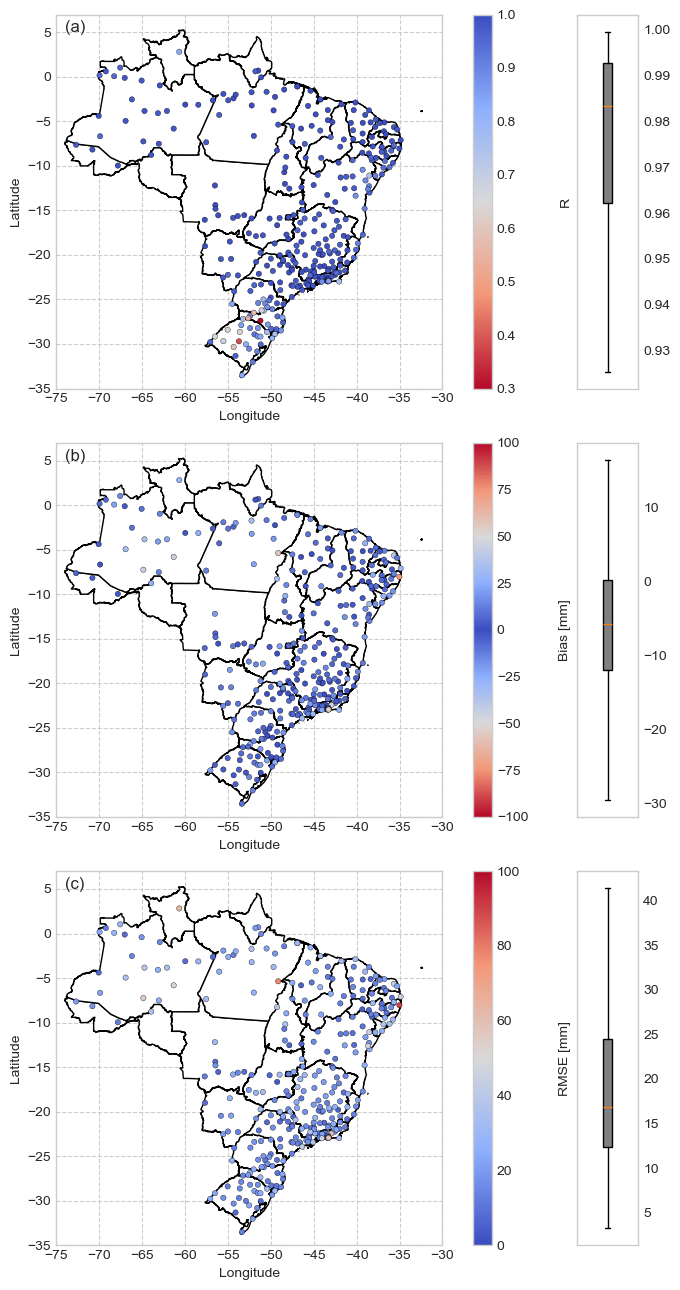

In [40]:
def createMap(df, column, label, letter, ax_map, ax_box, cmap, norm):
    br_map = geobr.read_state(year=2020)
    br_map.crs = "EPSG:4326"
    br_map['name_state'] = br_map['name_state'].apply(str.upper)
    br_map = br_map.sort_values(by=['name_state'])
    br_map['name_state'].replace({'AMAZÔNAS': 'AMAZONAS'}, inplace=True)

    # Plot the map
    br_map.plot(ax=ax_map, color='white', edgecolor='black')
    df.plot(ax=ax_map,
            column=column,
            legend=True,
            cmap=cmap,
            norm = norm,
            alpha=1.0,
            markersize=15,
            edgecolor = 'black',
            linewidth=0.25  # Adjust the thickness here
)

    ax_map.set_ylim([-35, 7])
    ax_map.set_xlim([-75, -30])
    ax_map.set_xlabel('Longitude')
    ax_map.set_ylabel('Latitude')
    ax_map.grid(ls='--')

    # Add letter annotation in the top-left corner
    ax_map.text(-74, 5, f"({letter})", fontsize=12)

    # Plot the boxplot
    ax_box.boxplot(df[column], vert=True, patch_artist=True, boxprops=dict(facecolor='grey'), showfliers=False)
    ax_box.set_ylabel(label)
    ax_box.yaxis.tick_right()  # Move ticks to the right
    ax_box.set_xticks([])  # Remove x-ticks for clarity

def create_all_maps(df):
    fig, axs = plt.subplots(3, 2, figsize=(7.5, 13), gridspec_kw={'width_ratios': [10, 1]})

    # R map
    createMap(df, 'R', 'R', 'a', axs[0, 0], axs[0, 1], r_cmap, r_norm)

    # Bias map
    createMap(df, 'Bias', 'Bias [mm]', 'b', axs[1, 0], axs[1, 1], bias_cmap, bias_norm)

    # RMSE map
    createMap(df, 'RMSE', 'RMSE [mm]', 'c', axs[2, 0], axs[2, 1], rmse_cmap, rmse_norm)

    plt.tight_layout()
    plt.savefig('./figures/Figura_9_climate_normal_R_Bias_RMSE_stations_1961_1990.tiff', format='tiff', dpi=300, transparent=False, bbox_inches='tight')
    plt.show()
    plt.close()

create_all_maps(df_geo)